In [1]:
# === Shared setup (run once at top) ===
from pathlib import Path
import pandas as pd, numpy as np, cv2, os, random, time

ROOT    = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW_DIR = ROOT / "data" / "raw_images"          # has 0..9 subfolders
WORK    = ROOT / "workspace"
CROPS_DIR = WORK / "crops_128"                   # normalized crops saved here
SPLITS  = WORK / "splits"
MODELS  = ROOT / "models"
IMG_SIZE = (128,128)                             # (W,H)
RNG_SEED = 42

for d in [WORK, CROPS_DIR, SPLITS, MODELS]: d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)


ROOT: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection


In [2]:
import os, cv2, json, shutil, numpy as np, pandas as pd
from pathlib import Path

C:\Users\sayu\AppData\Local\Temp\ipykernel_16368\2474761701.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index.astype(str), y=class_counts.values, palette="tab10")


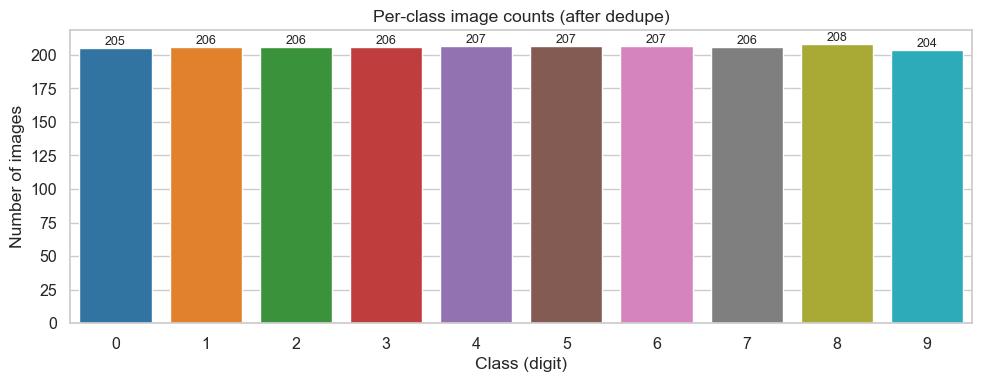

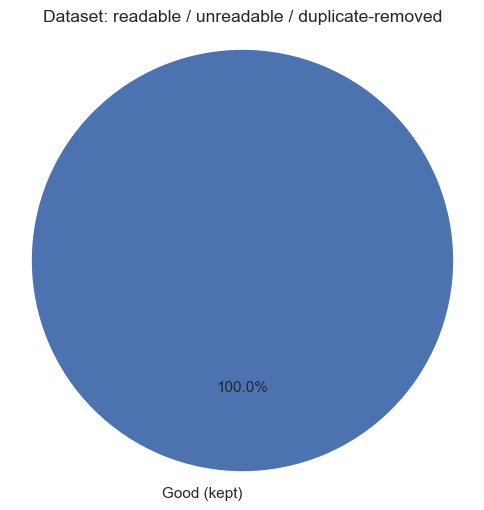

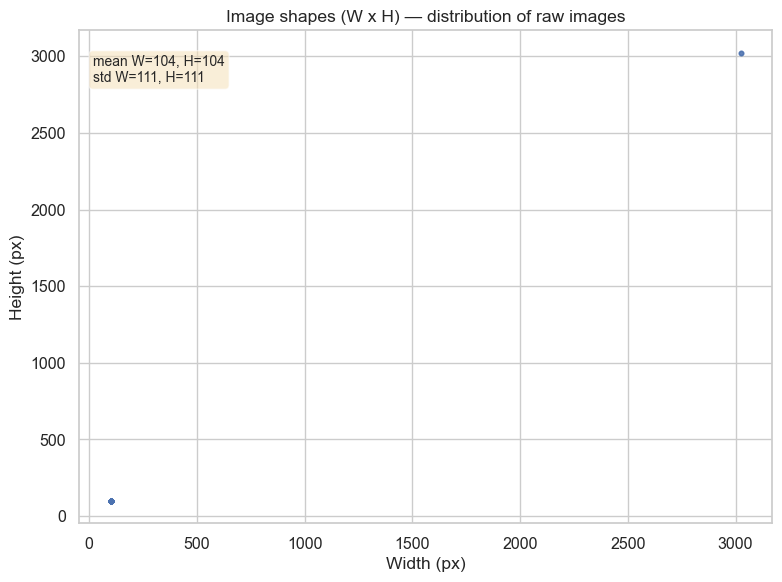

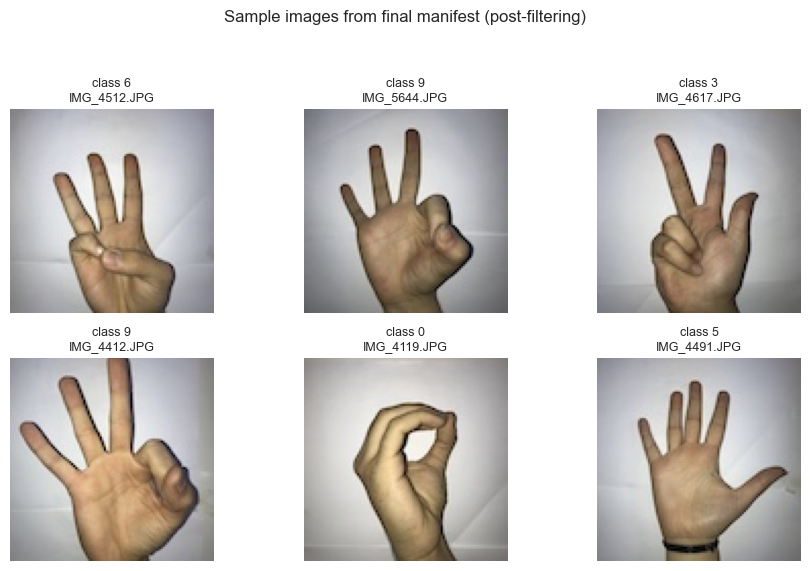

SUMMARY:
  Raw discovered files: 43
  Readable (kept before dedupe): 2062
  Unreadable (bad): 0
  Deduped: 2062 -> 2062 (removed 0 duplicates)
  Final manifest entries: 2062
  Per-class counts (after dedupe):
cls
0    205
1    206
2    206
3    206
4    207
5    207
6    207
7    206
8    208
9    204


In [46]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import cv2
import random

sns.set(style="whitegrid", font_scale=1.05)

# --- gather safe counts and stats (works with variables from Member-1) ---
total_raw = len(rows)                 # original discovered files
num_bad   = len(bad)                  # unreadable files list collected earlier
num_after = len(manifest)             # final (good + deduped) manifest
num_dedup_removed = total_raw - before
num_removed_by_bad = before - len(rows) if 'before' in globals() else num_bad

# per-class counts (manifest is final list after dedupe)
class_counts = manifest['cls'].value_counts().sort_index()

# image shapes array (list of (h,w))
shapes_arr = np.array(shapes) if len(shapes)>0 else np.empty((0,2))

# --- 1) Per-class counts bar chart ---
plt.figure(figsize=(10,4))
ax = sns.barplot(x=class_counts.index.astype(str), y=class_counts.values, palette="tab10")
ax.set_title("Per-class image counts (after dedupe)")
ax.set_xlabel("Class (digit)")
ax.set_ylabel("Number of images")
for i,p in enumerate(ax.patches):
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


# --- 2) Pie chart: good vs bad vs removed-by-dedup ---
labels = []
sizes = []
labels.append("Good (kept)")
sizes.append(num_after)
if num_bad>0:
    labels.append("Unreadable")
    sizes.append(num_bad)
# if dedup removed (before->after)
dedup_removed = before - num_after
if dedup_removed>0:
    labels.append("Removed (dupes)")
    sizes.append(dedup_removed)

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, textprops={'fontsize':11})
plt.title("Dataset: readable / unreadable / duplicate-removed")
plt.axis('equal')
plt.show()


# --- 3) Image shape scatter + marginals ---
if shapes_arr.shape[0] > 0:
    h = shapes_arr[:,0]; w = shapes_arr[:,1]
    plt.figure(figsize=(8,6))
    plt.scatter(w, h, alpha=0.5, s=10)
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.title("Image shapes (W x H) — distribution of raw images")
    # simple mean/std annotation
    plt.gca().annotate(f"mean W={w.mean():.0f}, H={h.mean():.0f}\nstd W={w.std():.0f}, H={h.std():.0f}",
                       xy=(0.02,0.95), xycoords='axes fraction', va='top', fontsize=10,
                       bbox=dict(boxstyle="round", fc="wheat", alpha=0.5))
    plt.tight_layout()
    plt.show()
else:
    print("No shape data collected (shapes list empty).")


# --- 4) Small grid of example images from final manifest ---
def show_examples(n=9, seed=RNG_SEED):
    rng = random.Random(seed)
    sample_rows = manifest.sample(n=min(n, len(manifest)), random_state=seed).to_dict('records')
    cols = min(3, len(sample_rows))
    rows_grid = (len(sample_rows)+cols-1)//cols
    plt.figure(figsize=(3*cols, 3*rows_grid))
    for i, r in enumerate(sample_rows):
        p, cls = r['path'], r['cls']
        img = cv2.imread(p)
        if img is None:
            img = np.zeros((128,128,3), dtype=np.uint8)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(rows_grid, cols, i+1)
        plt.imshow(img_rgb)
        plt.title(f"class {cls}\n{Path(p).name}", fontsize=9)
        plt.axis('off')
    plt.suptitle("Sample images from final manifest (post-filtering)", fontsize=12)
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()

show_examples(n=6, seed=RNG_SEED)


# --- Summary prints for quick reference ---
print("SUMMARY:")
print(f"  Raw discovered files: {total_raw}")
print(f"  Readable (kept before dedupe): {before}") 
print(f"  Unreadable (bad): {num_bad}")
print(f"  Deduped: {before} -> {num_after} (removed {dedup_removed} duplicates)")
print(f"  Final manifest entries: {num_after}")
print("  Per-class counts (after dedupe):")
print(class_counts.to_string())
